# Deconvolve Simulated Data with Periodic Functions

In [1]:
import anndata
import matplotlib.pylab as plt
import torch
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter

In [2]:
from ternadecov.simulator import *

# Configuration

In [3]:
n_iters = 10_000

# Load data

In [4]:
location_fascicularis = '/home/nbarkas/disk2/deconvolution_method/datasets/nhp_fascicularis_atlas/h5ad/'

h5ad_paths = {
    # Ebov Datasets
    "bulk_blood": "ebov_bulk.h5ad",
    "sc_blood": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad",
    "bulk_all": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/all_ebov_bulk.h5ad",
    
    
    # fascicularis
    "sc_adrenal": f"{location_fascicularis}/Adrenal_gland.h5ad",
    "sc_cerebellum": f"{location_fascicularis}/Cerebellum.h5ad",
    "sc_kidney": f"{location_fascicularis}/Kidney.h5ad",
    "sc_liver": f"{location_fascicularis}/Liver.h5ad",
    "sc_lung": f"{location_fascicularis}/lung.h5ad",
    "sc_lymph_node": f"{location_fascicularis}/Lymph_node.h5ad",
    "sc_neocortex": f"{location_fascicularis}/Neocortex.h5ad",
    "sc_pbmc": f"{location_fascicularis}/pbmc.h5ad",
    "sc_skin": f"{location_fascicularis}/Skin.h5ad",
    "sc_spleen": f"{location_fascicularis}/Spleen.h5ad",
    "sc_subcutaneous_adipose": f"{location_fascicularis}/Subcutaneous_adipose.h5ad",
    "sc_testis": f"{location_fascicularis}/Testis.h5ad",
    "sc_thyroid": f"{location_fascicularis}/Thyroid_gland.h5ad",
    "sc_uterus": f"{location_fascicularis}/Uterus.h5ad",
    "sc_vagina": f"{location_fascicularis}/Vagina.h5ad",
}

In [5]:
with open(h5ad_paths['bulk_all'], 'rb') as fh:
    all_bulk_anndata = anndata.read_h5ad(fh)

In [6]:
with open(h5ad_paths['sc_liver'], 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [7]:
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['dpi_time'] >=0,]
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['full.tissue'] == 'Liver',]

In [8]:
all_bulk_anndata.var.gene = all_bulk_anndata.var.gene.astype(str)
all_bulk_anndata.var = all_bulk_anndata.var.set_index('gene')

Trying to set attribute `.var` of view, copying.


In [9]:
datatype_param = DeconvolutionDatatypeParametrization()

In [10]:
ebov_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Abbreviation",
        bulk_anndata = all_bulk_anndata,
        bulk_time_col = "dpi_time",
        feature_selection_method = 'overdispersed_bulk_and_high_sc'
    )
)

/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.83965e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


log_sc_cutoff: 2
3974 genes selected


# Run Deconvolution

In [11]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolutionModel(
    dataset=ebov_dataset,
    trajectory_model_type='gp',
    hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
    trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
    types=datatype_param
)

In [12]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000)

[step: 0, time: 1 s ] loss: 7070891.96
[step: 1000, time: 15 s ] loss: 2076237.87
[step: 2000, time: 29 s ] loss: 905839.12
[step: 3000, time: 44 s ] loss: 544400.66
[step: 4000, time: 58 s ] loss: 403595.84
[step: 5000, time: 73 s ] loss: 336574.59
[step: 6000, time: 88 s ] loss: 303178.71
[step: 7000, time: 103 s ] loss: 285746.82
[step: 8000, time: 118 s ] loss: 276323.79
[step: 9000, time: 133 s ] loss: 270991.15


# Examine Outputs

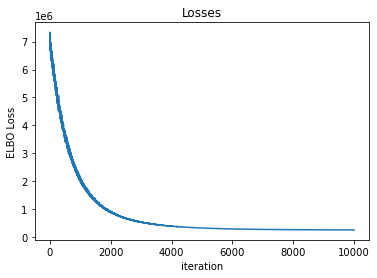

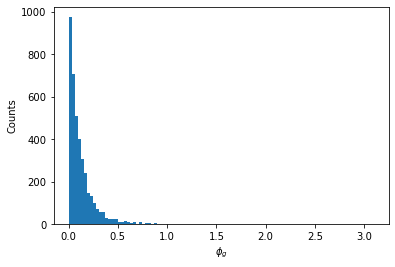

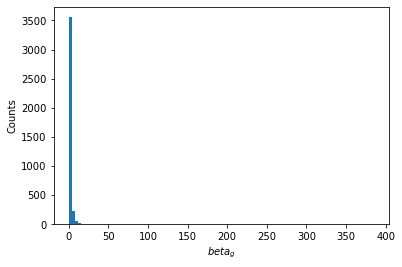

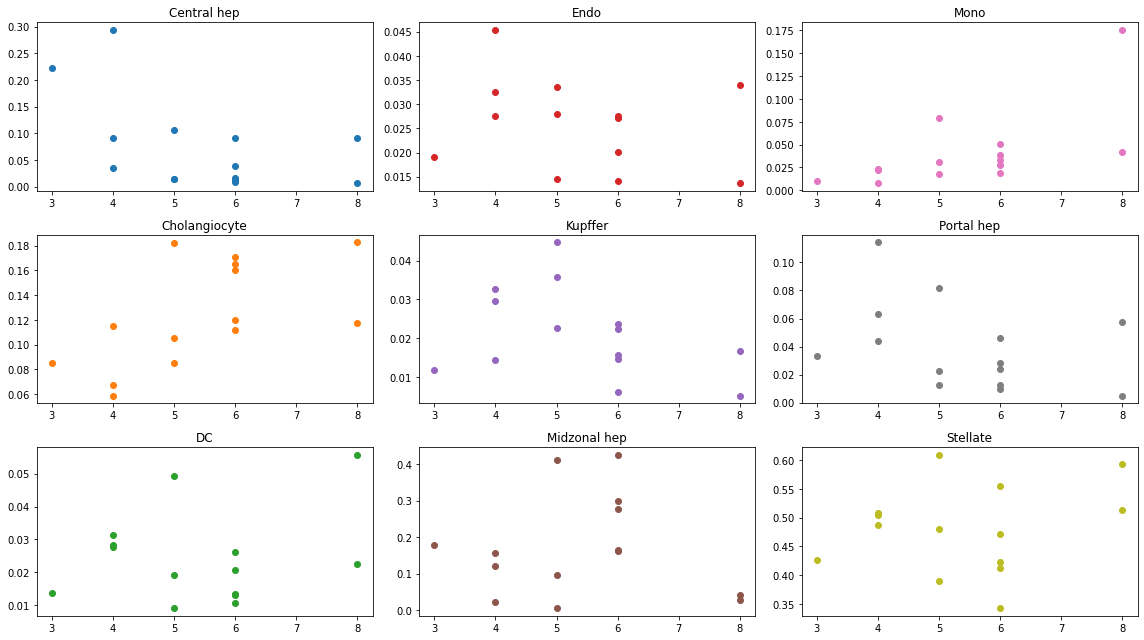

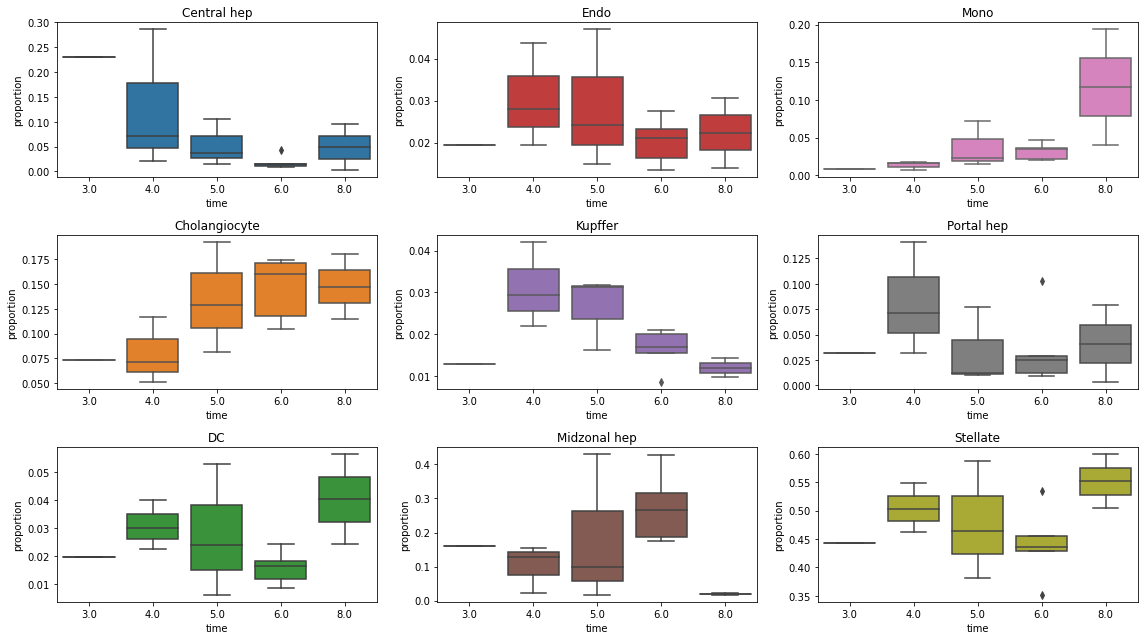

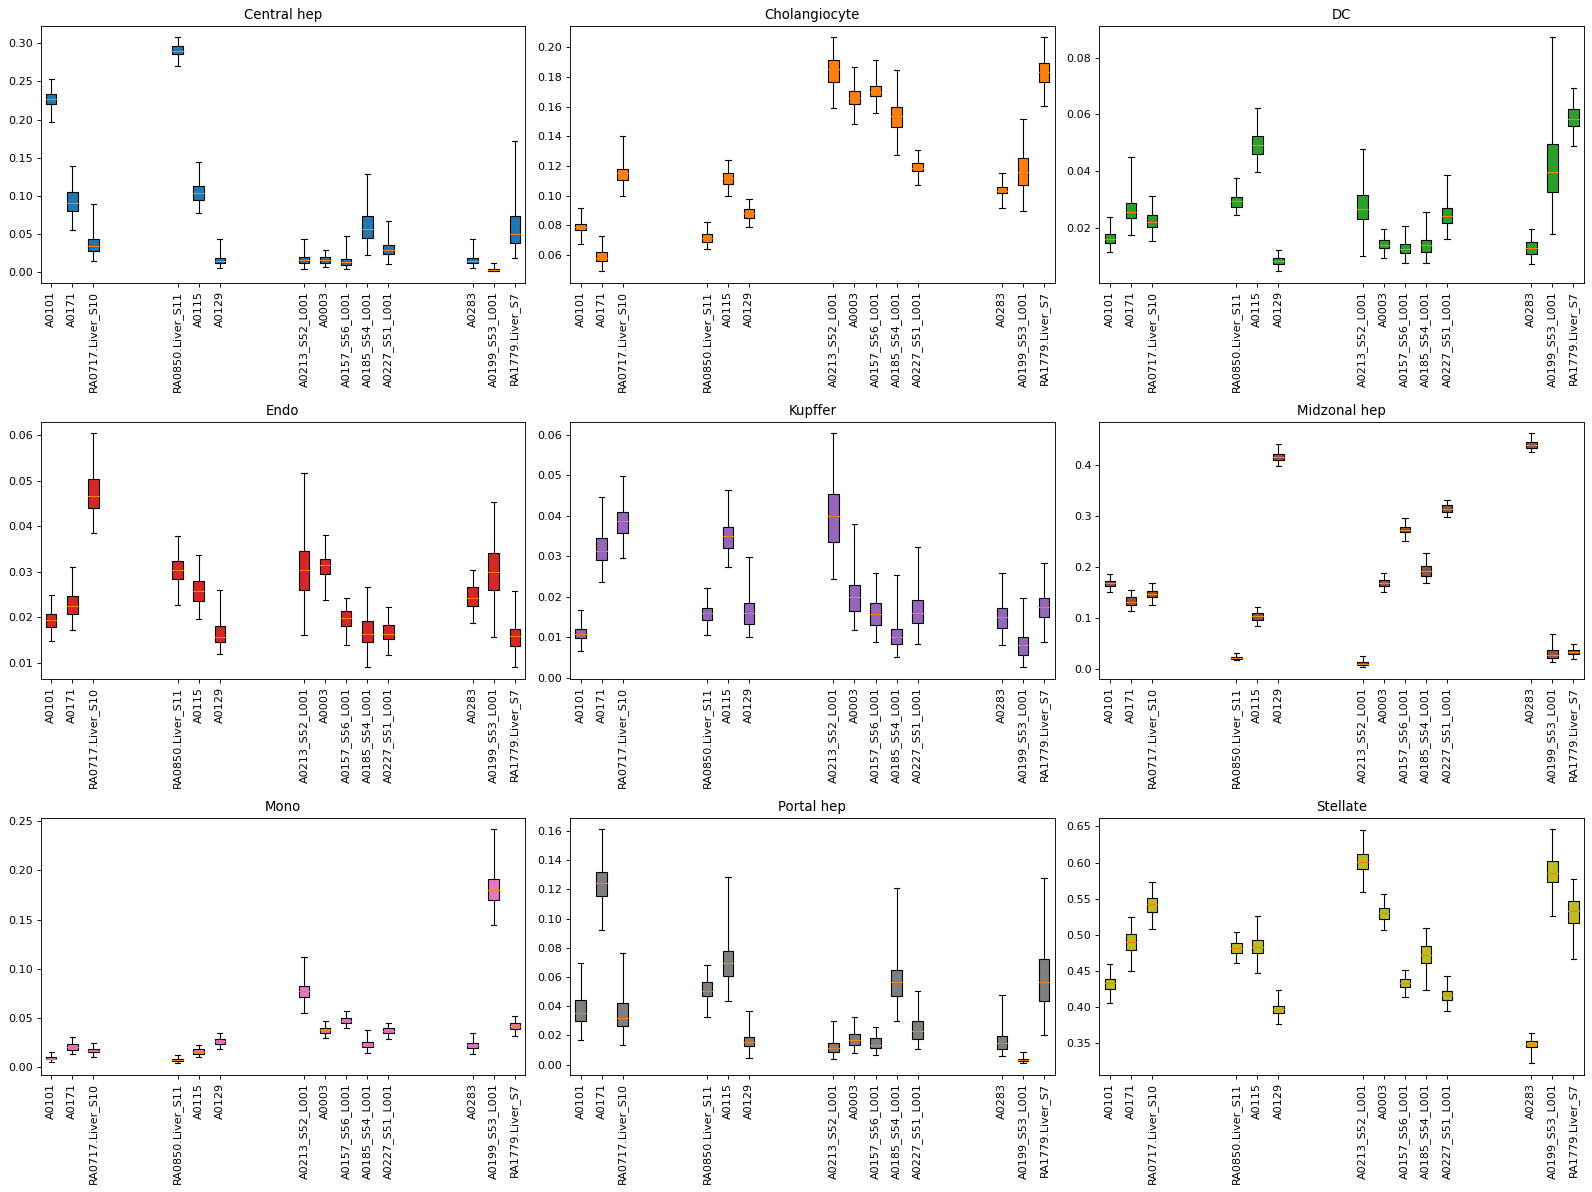

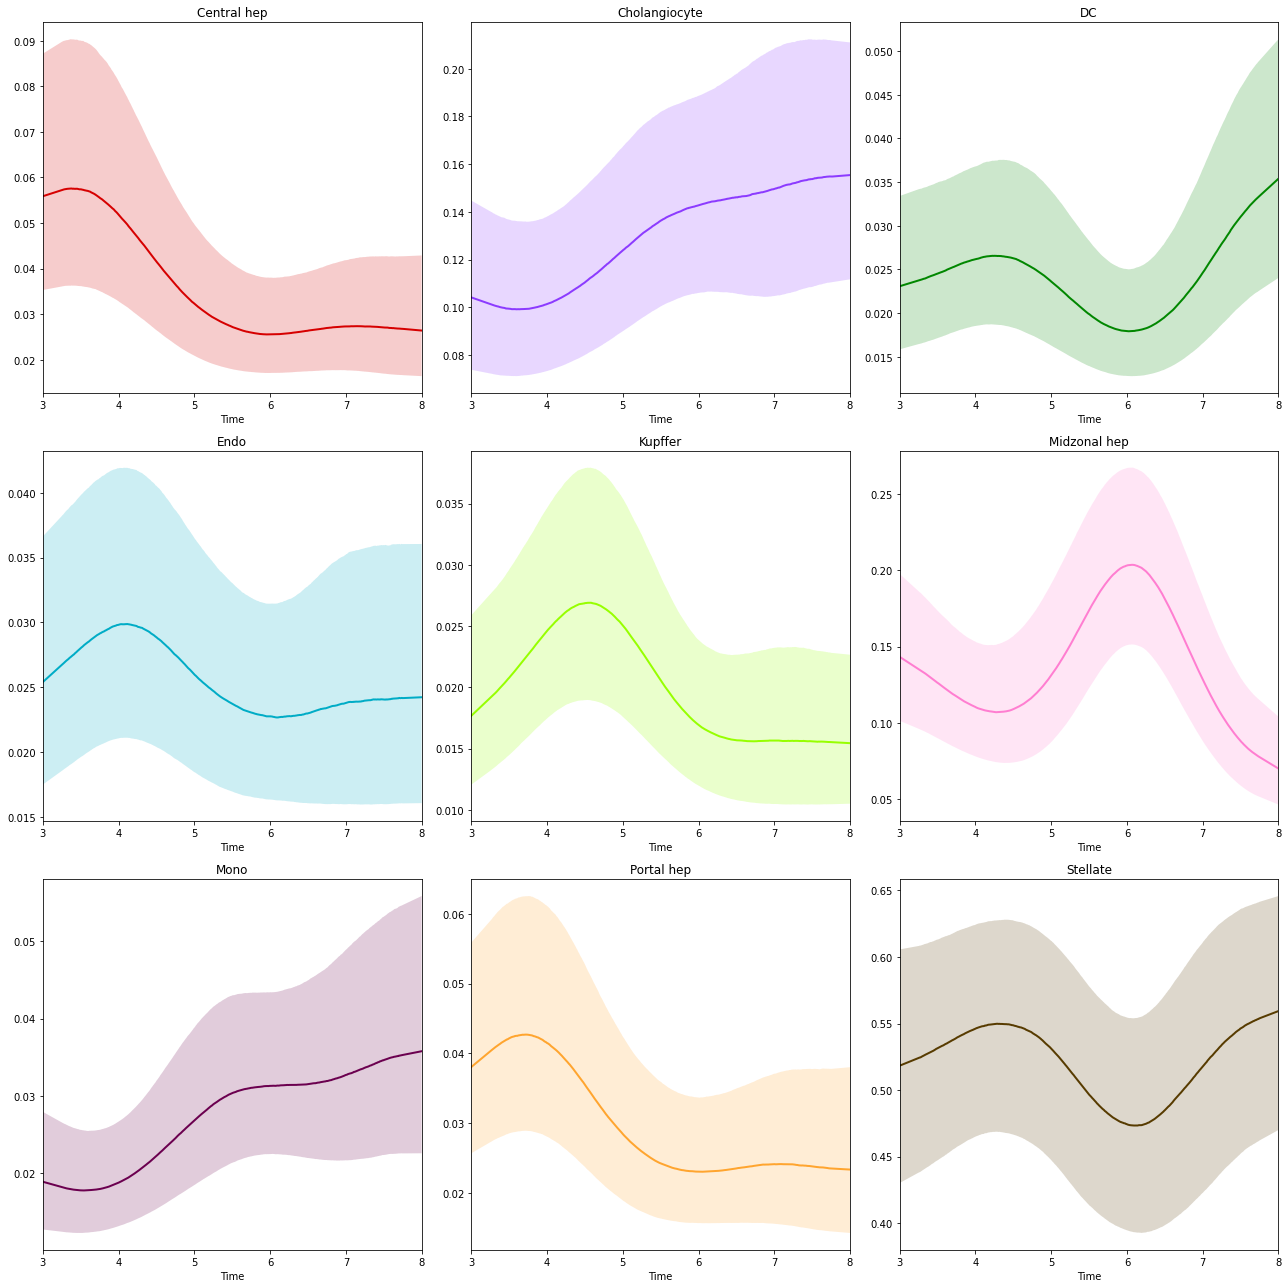

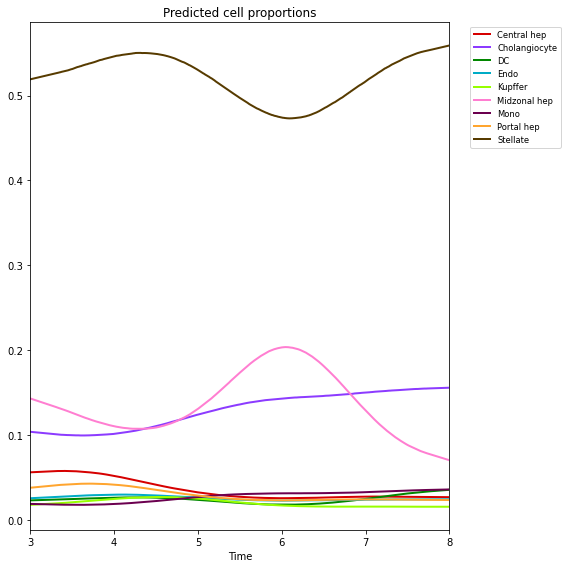

In [13]:
from ternadecov.deconvolution_exporter import DeconvolutionExporter
exporter = DeconvolutionExporter(pseudo_time_reg_deconv, prefix = 'liver_')
exporter.export_results('output/liver_sim_base/')

# Simulation

In [31]:
def simulation_trajectory_error_iteration(pseudo_time_reg_deconv, num_samples, n_iters = 10_000):
    pyro.clear_param_store()
    
    sim_res = simulate_data(
        num_samples=num_samples, 
        w_hat_gc = torch.Tensor(pseudo_time_reg_deconv.dataset.w_hat_gc),
        dirichlet_alpha = 1e10,
        trajectory_type = 'linear',
    )
    
    simulated_bulk = generate_anndata_from_sim(
        sim_res, 
        reference_dataset=pseudo_time_reg_deconv.dataset)
    
    ebov_simulated_dataset = DeconvolutionDataset(
        types=datatype_param,
        parametrization = DeconvolutionDatasetParametrization(
            sc_anndata = sc_anndata,
            sc_celltype_col = "Abbreviation",
            bulk_anndata = simulated_bulk,
            bulk_time_col = "time",
            feature_selection_method = 'common'
        )
    )
    
    pseudo_time_reg_deconv = TimeRegularizedDeconvolutionModel(
        dataset=ebov_simulated_dataset,
        trajectory_model_type='gp',
        hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
        trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
        types=datatype_param
    )

    pseudo_time_reg_deconv.fit_model(
        n_iters=n_iters, 
        verbose=True, 
        log_frequency=1000,
        clear_param_store = True,
        keep_param_store_history=False)
    
    return calculate_trajectory_prediction_error(sim_res, pseudo_time_reg_deconv)

In [32]:


def calculate_trajectory_prediction_error(
    sim_res, pseudo_time_reg_deconv_sim, n_intervals=1000
):
    """Calculate the prediction error of a deconvolution on simulated results

    :param sim_res: results of a simulation
    :param pseudo_time_reg_deconv_sim: the deconvolution object to evaluate
    :n_intervals: number of intervals over which to evaluate the results
    """

    # TODO: Move to sim_res
    start_time = -5
    end_time = 5
    step = (end_time - start_time) / n_intervals

    t_m = torch.arange(start_time, end_time, step)
    num_samples = t_m.shape[0]

    # Get the ground truth
    if sim_res["trajectory_params"]["type"] == "sigmoid":
        shift = sim_res["trajectory_params"]["shift"]
        effect_size = sim_res["trajectory_params"]["effect_size"]
        num_cell_types = sim_res["trajectory_params"]["effect_size"].shape[0]

        cell_pop_cm = torch.zeros(num_cell_types, num_samples)
        for i in range(num_cell_types):
            cell_pop_cm[i, :] = torch.Tensor(
                list(sigmoid(effect_size[i] * x + shift[i]) for x in t_m)
            )
        ground_truth_proportions_cm = torch.nn.functional.softmax(cell_pop_cm, dim=0).T
    elif sim_res["trajectory_params"]["type"] == "linear":
        a = sim_res["trajectory_params"]["a"]
        b = sim_res["trajectory_params"]["b"]
        num_cell_types = sim_res["trajectory_params"]["trajectories_cm"].shape[0]

        cell_pop_cm = torch.zeros(num_cell_types, num_samples)
        for i in range(num_cell_types):
            cell_pop_cm[i, :] = torch.Tensor(list(a[i] * x + b[i] for x in t_m))
        ground_truth_proportions_cm = torch.nn.functional.softmax(cell_pop_cm, dim=0).T
    elif sim_res["trajectory_params"]["type"] == "periodic":
        a = sim_res["trajectory_params"]["a"]
        b = sim_res["trajectory_params"]["b"]
        c = sim_res["trajectory_params"]["c"]
        num_cell_types = sim_res["trajectory_params"]["trajectories_cm"].shape[0]

        cell_pop_cm = torch.zeros(num_cell_types, num_samples)
        for i in range(num_cell_types):
            cell_pop_cm[i, :] = torch.Tensor(
                list(a[i] * torch.sin(b[i] * x + c[i]) for x in t_m)
            )
        ground_truth_proportions_cm = torch.nn.functional.softmax(cell_pop_cm, dim=0).T
    else:
        raise Exception(
            f'Unknown trajectory type { sim_res["trajectory_params"]["type"] }'
        )

    # Get the predictions
    traj = pseudo_time_reg_deconv_sim.population_proportion_model.get_composition_trajectories(
        dataset=pseudo_time_reg_deconv_sim.dataset, n_intervals=n_intervals
    )
    ret_vals = traj

    predicted_composition_cm = ret_vals["norm_comp_tc"]

    # Calculate L1 and L2 losses
    L1_error = (
        (ground_truth_proportions_cm - predicted_composition_cm).abs().sum([0, 1])
    )
    L1_error_norm = L1_error / n_intervals
    L2_error = (
        (ground_truth_proportions_cm - predicted_composition_cm)
        .pow(2)
        .sum([0, 1])
        .sqrt()
    )
    L2_error_norm = L2_error / n_intervals

    # Calculate L1 and L2 losses on the trajectory shapes

    # Normalize by cell type summing to 1
    ground_truth_proportions_norm_cm = (
        ground_truth_proportions_cm / ground_truth_proportions_cm.sum(-2)
    )
    predicted_composition_norm_cm = (
        predicted_composition_cm / predicted_composition_cm.sum(-2)
    )

    shape_L1_error = (
        (ground_truth_proportions_norm_cm - predicted_composition_norm_cm)
        .abs()
        .sum([0, 1])
    )

    return {
        "L1_error": L1_error,
        "L1_error_norm": L1_error_norm,
        "L2_error": L2_error,
        "L2_error_norm": L2_error_norm,
        "shape_L1_error": shape_L1_error,
    }


In [57]:
n_iters = 10_000

n_samples = []
replicate = []
errors = [] 

for n in range(5,30,5):
    for r in range(1,3):
        print(f'Processing n={n}, r={r}')
        l1_error_norm = simulation_trajectory_error_iteration(pseudo_time_reg_deconv, n, n_iters=n_iters)['L1_error_norm']
        n_samples.append(n)
        replicate.append(n)
        errors.append(l1_error_norm.item())

Processing n=5, r=1


/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


log_sc_cutoff: 2
3974 genes selected
[step: 0, time: 1 s ] loss: 329587.88
[step: 1000, time: 12 s ] loss: 163273.90
[step: 2000, time: 24 s ] loss: 128857.41
[step: 3000, time: 35 s ] loss: 115034.40
[step: 4000, time: 47 s ] loss: 110650.63
[step: 5000, time: 59 s ] loss: 110943.53
[step: 6000, time: 70 s ] loss: 108132.71
[step: 7000, time: 82 s ] loss: 107503.60
[step: 8000, time: 94 s ] loss: 107106.33
[step: 9000, time: 105 s ] loss: 106988.08
Processing n=5, r=2
log_sc_cutoff: 2
3974 genes selected
[step: 0, time: 1 s ] loss: 280084.19
[step: 1000, time: 12 s ] loss: 171468.93
[step: 2000, time: 24 s ] loss: 128453.45
[step: 3000, time: 36 s ] loss: 115992.14
[step: 4000, time: 47 s ] loss: 112507.20
[step: 5000, time: 59 s ] loss: 110192.00
[step: 6000, time: 71 s ] loss: 109359.12
[step: 7000, time: 82 s ] loss: 108803.96
[step: 8000, time: 94 s ] loss: 108519.20
[step: 9000, time: 105 s ] loss: 108390.80
Processing n=10, r=1
log_sc_cutoff: 2
3974 genes selected
[step: 0, time

In [58]:
df1 = pd.DataFrame(
 {'n_samples': n_samples,
  'replicate': replicate,
  'errors': errors}
)

In [59]:
import seaborn as sns

Text(0, 0.5, 'Normalized L1-error')

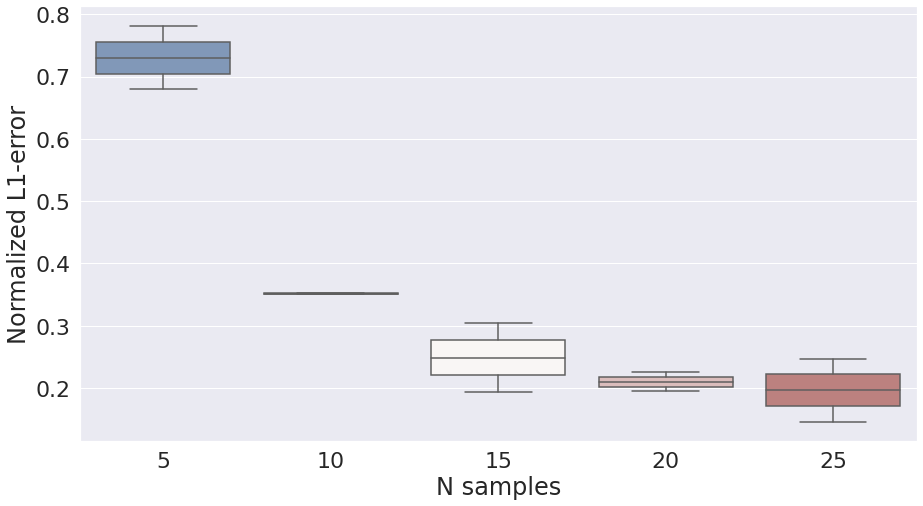

In [77]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale=2)
              
p = sns.boxplot(x=n_samples, y=errors, palette='vlag')
p.set_xlabel('N samples')
p.set_ylabel('Normalized L1-error')
